# Retraining of VGG model for use in case of breast cancer images. 

In [1]:
import scipy.io as sio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
data = sio.loadmat('histo_images.mat')

In [2]:
X = data['histo_images']
y = data['labels']

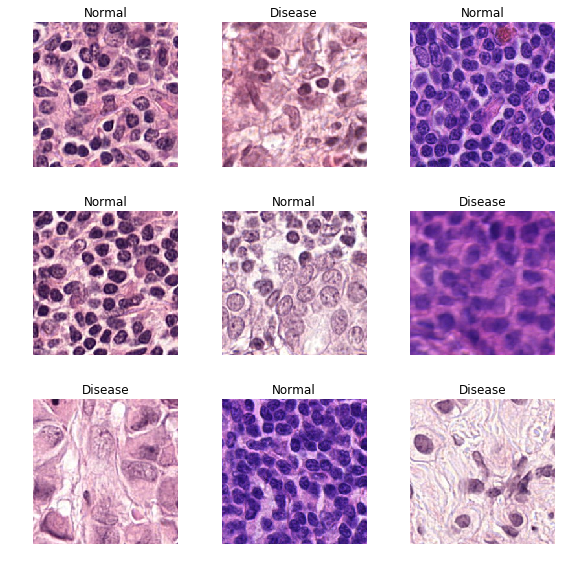

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))

for i, ax in enumerate(axes.flat, start=1):
    ii = np.random.randint(0, len(y))
    ax.imshow(X[:,:,:,ii])
    ax.axis('off')
    if y[ii][0] == 1:
        ax.set_title('Normal')
    else:
        ax.set_title('Disease')

fig.tight_layout()

plt.show()

In [29]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input


img_width, img_height = (X.shape[0], X.shape[1])

#Define model
model = applications.VGG19(weights = "imagenet", include_top=True, input_shape = (img_width, img_height, 3))
model = Model(inputs=model.input, outputs=model.get_layer('fc1').output)

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [31]:
#Forward pass

x = image.img_to_array(X[:,:,:,0])
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)
print(features.flatten().shape)

(4096,)


In [52]:
n = X.shape[3]
features_all = np.zeros((n, features.flatten().shape[0]))
for i in range(n):
    if i % 50 == 0:
        print(i)
    x = image.img_to_array(X[:,:,:,i])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    features_all[i,:] = features.flatten()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [61]:
from sklearn import neighbors, datasets
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import normalize
normed = normalize(features_all)

knn = neighbors.KNeighborsClassifier(n_neighbors = 11)

knn.fit(normed, y.ravel()-1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

In [65]:
pred = knn.predict(features_all)
print(accuracy_score(y.ravel()-1, pred))

0.880040322581


In [67]:
## It is seen that we acheive a 88% accuracy on our data with the KNN approach with 11 neighbours